# Module 1.1 Feature Cleanup Analysis.ipynb

This notebook extracts the raw trade data from combined_files.zip, cleans it, removes any future-looking columns, fixes missing values, checks for highly correlated features, and then saves the cleaned data for the next steps in feature engineering

In [1]:
import pandas as pd, numpy as np, zipfile, io, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
DATA_DIR = Path('data')
RAW_DIR = DATA_DIR / 'raw'
INTERIM_DIR = DATA_DIR / 'interim'
INTERIM_DIR.mkdir(parents=True, exist_ok=True)


## Loading the dataset (Combined_files.zip)

In [12]:
zip_path = RAW_DIR / 'combined_files.zip'

if zip_path.exists():
    with zipfile.ZipFile(zip_path) as zf:
        df = None

        # Iterate through files and load the first CSV or Parquet
        for name in zf.namelist():
            if name.endswith('.csv'):
                df = pd.read_csv(io.BytesIO(zf.read(name)))
                break
            elif name.endswith('.parquet'):
                df = pd.read_parquet(io.BytesIO(zf.read(name)))
                break

        if df is None:
            raise ValueError("No CSV or Parquet file found in combined_files.zip")

        print(f"Loaded rows: {len(df)}")
else:
    raise FileNotFoundError("combined_files.zip not found in data/raw/")

display(df.head())


Loaded rows: 46652


,trade_id,name,symbol,signal,strategy,entry_date,exit_date,entry_cost,exit_cost,pnl,...,min_put_wall_strike_perc_exp_mean,min_put_wall_strike_low_vs_hist,min_put_wall_strike_high_vs_hist,min_put_wall_strike_not_near,neutral_zone,call_wall_compression,put_wall_compression,short_gamma_expansion,gamma_valley,wall_to_wall_compression
0,0,renko_AAPL_long_1.0_1.0,AAPL,3,stock_only,2023-04-24 17:15:00+00:00,2023-04-24 19:50:00+00:00,164.68,-165.1786,0.4986,...,-0.027566,False,True,False,False,False,False,True,False,False
1,1,renko_AAPL_long_1.0_1.0,AAPL,16,stock_only,2023-05-03 13:35:00+00:00,2023-05-03 14:15:00+00:00,170.27,-170.2200,-0.0500,...,-0.033318,True,False,True,False,False,False,False,True,True
2,2,renko_AAPL_long_1.0_1.0,AAPL,17,stock_only,2023-05-03 16:00:00+00:00,2023-05-03 19:10:00+00:00,169.73,-168.8800,-0.8500,...,-0.033318,True,False,True,False,False,False,False,True,True
3,3,renko_AAPL_long_1.0_1.0,AAPL,27,stock_only,2023-05-10 18:10:00+00:00,2023-05-10 19:50:00+00:00,172.74,-173.5250,0.7850,...,-0.035424,False,True,True,False,True,True,False,False,True
4,4,renko_AAPL_long_1.0_1.0,AAPL,28,stock_only,2023-05-11 14:50:00+00:00,2023-05-11 17:50:00+00:00,173.13,-173.4101,0.2801,...,-0.034841,False,True,True,False,True,True,False,False,True


## Drop lookahead and non-predictive columns

In [13]:
# Columns that should always be removed from the raw trade data
drop_cols = ['exit_date', 'exit_cost', 'pnl', 'entry_cost', 'name', 'strategy']

# Drop only the columns that actually exist in the dataframe
cols_to_drop = [col for col in drop_cols if col in df.columns]
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# Create a binary label:
# 1 → profitable trade (pnl > 0)
# 0 → non-profitable trade
if 'pnl' in df.columns:
    df_clean['label'] = (df['pnl'] > 0).astype(int)
else:
    # Fallback label if pnl is missing
    df_clean['label'] = 0

print(f"Dropped columns: {cols_to_drop}")
print(f"Remaining columns after cleaning: {len(df_clean.columns)}")


Dropped columns: ['exit_date', 'exit_cost', 'pnl', 'entry_cost', 'name', 'strategy']
Remaining columns after cleaning: 32


## Handle missing values

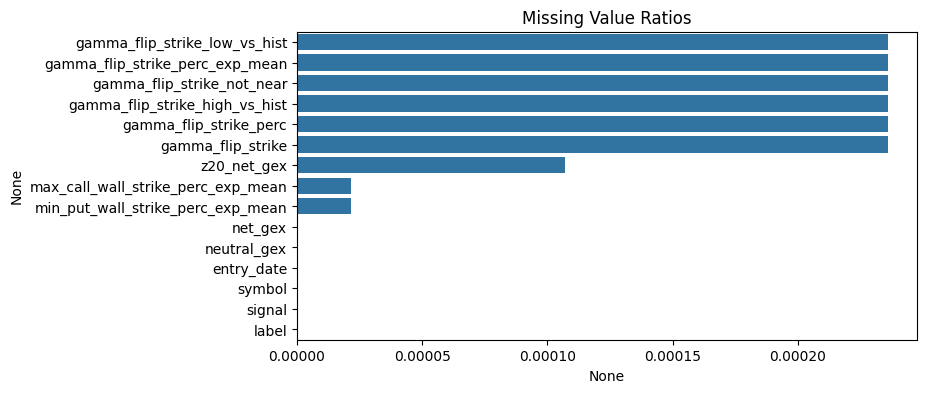

Dropped columns with >50% NA: []


In [5]:
na_ratio = df_clean.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=na_ratio.head(15), y=na_ratio.head(15).index)
plt.title('Missing Value Ratios')
plt.show()

threshold = 0.5
drop_na_cols = na_ratio[na_ratio > threshold].index.tolist()
df_clean = df_clean.drop(columns=drop_na_cols)

# fill remaining NaNs
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))
print('Dropped columns with >50% NA:', drop_na_cols)

## Remove low variance & highly correlated features

In [14]:
# --- Variance Threshold (remove near-constant numeric features) ---
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=1e-5)

# Select only numeric columns
num_cols = df_clean.select_dtypes(include=np.number).columns
df_var = df_clean[num_cols].copy()

# Fit selector and keep only columns with sufficient variance
selector.fit(df_var)
kept_cols = num_cols[selector.get_support()]
df_var = df_var[kept_cols]

# --- Correlation Filtering (remove highly correlated features) ---
corr_matrix = df_var.corr().abs()

# Upper triangle mask (avoid duplicate checks)
upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))

# Identify columns with correlation > 0.95
to_drop = [
    col for col in upper.columns 
    if any(upper[col] > 0.95)
]

print("Highly correlated columns dropped:", to_drop)

# Drop correlated columns
df_var = df_var.drop(columns=to_drop)

# --- Recombine with non-numeric Features ---
non_numeric = df_clean.drop(columns=num_cols)
df_final = pd.concat([non_numeric, df_var], axis=1)

# --- Save cleaned output ---
output_path = INTERIM_DIR / "cleaned_trades.parquet"
df_final.to_parquet(output_path, index=False)
print("Saved cleaned dataset:", output_path)


Highly correlated columns dropped: ['max_call_wall_strike', 'max_call_wall_strike_perc', 'max_call_wall_strike_perc_exp_mean', 'min_put_wall_strike', 'min_put_wall_strike_perc', 'min_put_wall_strike_perc_exp_mean']
Saved cleaned dataset: data\interim\cleaned_trades.parquet


## Train/Test Split (saved for convenience)

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# --- Prepare features and labels ---
X = df_final.drop(columns=['label'], errors='ignore')
y = df_final['label']

# --- Stratified Train/Test Split (80/20) ---
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, test_idx = next(sss.split(X, y))

train_df = df_final.iloc[train_idx]
test_df = df_final.iloc[test_idx]

# --- Save Outputs ---
train_path = INTERIM_DIR / "train_pre_split.parquet"
test_path = INTERIM_DIR / "test_pre_split.parquet"

train_df.to_parquet(train_path, index=False)
test_df.to_parquet(test_path, index=False)

print("Train/Test split completed.")
print("Train saved to:", train_path)
print("Test saved to:", test_path)


Train/Test split completed.
Train saved to: data\interim\train_pre_split.parquet
Test saved to: data\interim\test_pre_split.parquet


## Basic Statistics & Correlation Heatmap

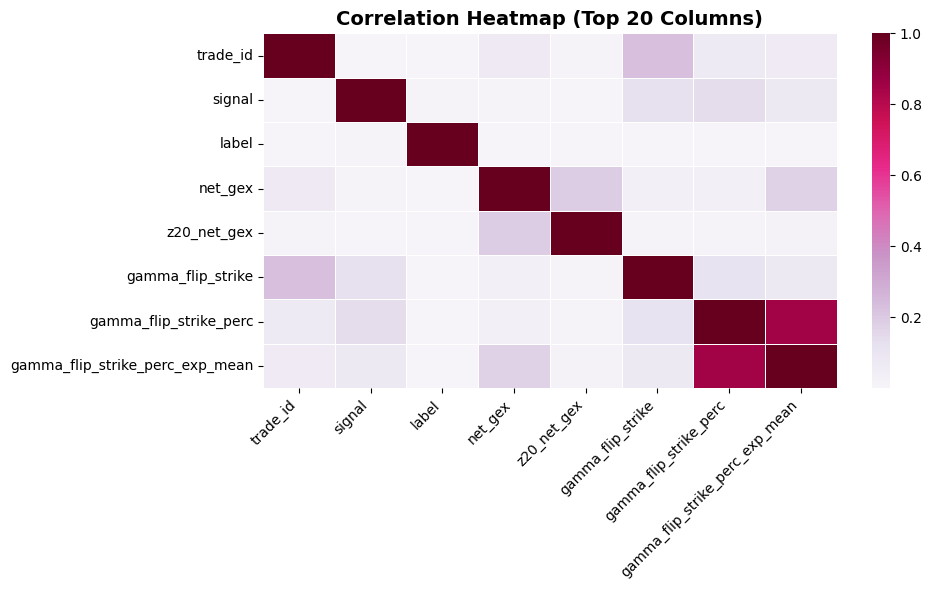

,count,mean,std,min,25%,50%,75%,max
trade_id,46652.0,2.332550e+04,1.346742e+04,0.000000e+00,11662.750000,2.332550e+04,3.498825e+04,4.665100e+04
signal,46652.0,6.463949e+02,3.747283e+02,0.000000e+00,325.000000,6.430000e+02,9.670000e+02,1.574000e+03
label,46652.0,4.312355e-01,4.952542e-01,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,1.000000e+00
net_gex,46652.0,9.194507e+06,6.009260e+07,-6.653617e+08,-544713.189506,1.050405e+06,6.653217e+06,6.237220e+09
z20_net_gex,46647.0,-2.543307e-03,1.251521e+00,-4.246150e+00,-0.928112,-5.348297e-02,9.212572e-01,4.245023e+00
gamma_flip_strike,46641.0,3.698190e+02,6.310217e+02,1.400000e+01,109.000000,1.980000e+02,4.120000e+02,5.730000e+03
gamma_flip_strike_perc,46641.0,2.016773e-01,1.314994e+00,-3.120000e-01,-0.018453,-2.856327e-04,1.769722e-02,1.008947e+01
gamma_flip_strike_perc_exp_mean,46641.0,3.203978e-01,1.540953e+00,-6.097693e-02,-0.005570,-1.522979e-03,2.842491e-03,9.132898e+00


In [20]:
plt.figure(figsize=(10, 6))

sns.heatmap(
    df_var.corr().abs().head(20),
    annot=False,
    cmap='PuRd',        
    linewidths=0.4,
    linecolor='white'
)

plt.title('Correlation Heatmap (Top 20 Columns)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display summary statistics
display(df_final.describe().T.head(15))
